Se importan las bibliotecas necesarias para obtener el fasor y angulo de la señal en falla 

In [1]:
import pandas as pd ## Manipulación y creación de DataFrame
import numpy as np ## Manipulación matematica de los datos
import matplotlib.pyplot as plt ## Representación grafica de los datos 

Se instala la biblioteca comtrade, para posteriormente invocar la biblioteca 

In [2]:
!pip install comtrade ## Se instala la biblioteca 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Se invoca la biblioteca 

In [3]:
from comtrade import Comtrade ## Carga y lectura del formato Comtrade

## Carga de los Datos 

Se realiza la lectura de un archivo Comtrade, nombrando la función Comtrade(), como "rec", posteriormente se usa la acción .load(), que recibe como entrada la ubicación del archivo en el Drive, la biblioteca necesita solamente el archivo .cfg, sin embargo, realiza la lectura del archivo .dat también 


Es importante anotar que, la acción .load() recibe 1. la ubicación del archivo y 2. la codificación "encoding =", para el caso de Siemens es será "ISO-8859-1", las demas marcas no necesitan especificar, el tipo de codificación, esto se debe a la caracteristica de decodificación de cada marca, esta información se encuentra en el archivo .cfg, como se ve a continuación:  

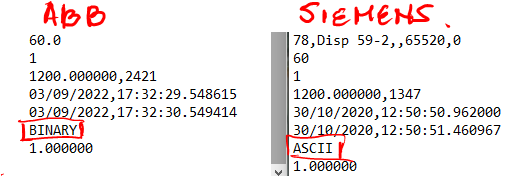

Como es el caso de ABB es BINARY el cual no necesita de decodificación, a diferencia de SIEMENS que es ASCII

In [4]:
rec = Comtrade() ## Se define la función Comtrade()
rec.load(r'/content/drive/MyDrive/Análisis de eventos /2021FEB/20210209 034216 BL1NOR-PUR PP2.cfg',encoding = "ISO-8859-1")## Cargamos la ubicación del archivo

/usr/local/lib/python3.9/dist-packages/comtrade.py:397: Warning: Unknown standard revision "1997"
  warnings.warn(Warning(msg))


*Acciones de la biblioteca Comtrade:* 

1. .time -----------> Vector tiempo
2. .analog ----------> Matriz de señales analogas 
3. .digital ----------> Matriz de señales digitales 

Se define el vector del tiempo, aplicando la función .time, posteriormente se convierte en un dataframe para unirlo con las señales analogas 

In [5]:
time = pd.DataFrame(rec.time, columns =['t'])
data = pd.DataFrame(data = np.transpose(rec.analog),columns = rec.analog_channel_ids )
data = pd.concat([time,data],axis=1)

## Datos 

Se verifica la forma del dataframe data, el cual debe tener su primera columna definida como el tiempo, y las demas columnas las señales analogicas, con los respectivos nombres.

In [6]:
data.head()

,t,iA,iB,iC,iN,vA,vB,vC,vSYN2
0,0.000000,0.516096,-0.299520,-0.198144,-0.018432,-94.528679,57.490795,36.471844,98.689072
1,0.000833,0.493056,-0.147456,-0.331776,-0.009216,-94.896606,31.632202,62.292702,56.132301
2,0.001667,0.428544,0.009216,-0.437760,-0.004608,-84.283356,2.594350,81.330513,5.745306
3,0.002500,0.327168,0.170496,-0.502272,0.000000,-64.707809,-27.151052,92.745651,-46.217167
4,0.003333,0.188928,0.308736,-0.502272,0.004608,-40.151104,-54.688896,96.481522,-93.264526


In [7]:
data.iloc[:,5:] = data.iloc[:,5:] * np.sqrt(3)

## Función fasor

Objetivo: Esta función tiene como objetivo, tomar la señal obtenida del formato COMTRADE, y obtener la magnitud y ángulo de la señal 


*   Entradas: vector (Señal de la cual que queremos obtener la magnitud y angulo) y vector_t (Vector tiempo de la señal vector) 
*   Salidas: Magnitud de la señal y Angulo



Función vector_fasor:
objetivo: obtener el numero de periodos en la señal, y crear un vector de 0 al tamaño de la señal, con pasos del numero de muestras por periodo 

In [8]:
def vector_f(vector,t_vector):
  fm = (data.index[t_vector<=(1/60)]).max() + 1 ## numero de muestras antes de cumplir un periodo, se toma el maximo para saber cuantas muestras hay por periodo, +1 puesto que python tiene en cuenta el 0
  vector_fasor = list(np.arange(0,len(vector),fm)) ## Se realiza un vector de 0 a el tamaño de la señal en paso del numero de muestras por periodo  
  tm = t_vector[vector_fasor] ## Los puntos del tiempo donde inician los periodos 
  return vector_fasor, tm

Se definen dos listas vacias, que al ejecutarse el ciclo for será llenando, j se define como contador, este va de unidad en unidad desde 0 hasta el tamaño del vector que contiene el numeros de periodos en toda la señal 

```
    abs_vector=[]
    ang_vector=[]
    j = 0 
```

 Posterior a esto se realiza el ciclo for, este recorre el vector_fasor, recordemos, que esta variable contiene los indices del inicio de los periodos durante toda la señal
```
    for i in vector_fasor:
```
Se realiza este "for" puesto que realizamos la transformada rapida de fourier sobre los periodos contenidos en la señal.

Tenemos dos opciones, asi que se aplica un condicional "if-else", el primero es cuando se tiene el tamaño suficiente para aplicar la fft, y el segundo se debe a que se puede presentar un tamaño de señal que al dividir sobre el numero de muestras por periodo no de como resultado un numero entero, en este caso se toma la muestra hasta el final.

En el caso de este Comtrade tenemos un tamaño de señal 6003 y un numero de muestras de 20 por periodo, al dividir 6003/20 obtendremos 300.15 muestras para aplicar fft(), sin embargo al no ser un numero entero tenemos como resultado obtendremos 6000/20 = 300 muestras completas para aplicar la fft() que entran en el grupo 1, (en el if), y tenemos una muestra desde 6000 hasta 6003, a la cual aplicaremos fft() que entra en la opción 2, (en el else)

```
    for i in vector_fasor:
```

```
        if (i < vector_fasor[len(vector_fasor)-1]):
        N = len(vector[vector_fasor[j]:(vector_fasor[j+1])])
        vector_fft = np.fft.fft(vector[vector_fasor[j]:(vector_fasor[j+1])])*2/(N)
        ang_fft = np.angle(vector_fft[1])
        vector_fft = sum(abs(vector_fft[1:10])) 
```
Al entrar al if se mide el tamaño de la muestra, deacuerdo a la iteración y se le define como N, posterior a esto se le aplica la fft() por medio de la función np.fft.fft, Se divide por N, para normalizar el resultado y se multiplica por 2 debido a la duplicidad obtenida por las frecuencias de la componente imaginaria, que al obtener la magnitud, nos implica la mitad de la magnitud correcta, vector_fft = obtiene la sumatoria de los valores absolutos de la señal, hasta la mitad del tamaño nuevamente ocasionado por el reflejo del componente imaginario, ang_fft = obtiene el angulo, para la fundamental, ubicado en la posición 1, quiere decir 60 Hz

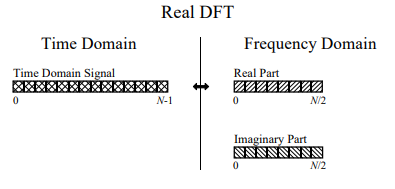

Bibliografia FFT() : http://www.dspguide.com/CH12.PDF

Al entrar al else, como se indico antes, la muestra a la cual se le aplicara sera incompleta, lo unico que cambia frente al if el punto final estará dado por el tamaño de la señal 



```
        N = len(vector[j:])
        vector_fft = np.fft.fft(vector[j:])*2/(N)
        vector_fft_cmplx = sum(vector_fft[1:10]) 
        ang_fft = np.angle(vector_fft[1])
        vector_fft = sum(abs(vector_fft[1:10]))
```



In [9]:
def fft_mag(vector,t_vector): 
    vector_fasor,tm = vector_f(vector, t_vector)     
    abs_vector=[]
    ang_vector=[]
    j = 0
    for i in vector_fasor:

      if (i < vector_fasor[len(vector_fasor)-1]):
        N = len(vector[vector_fasor[j]:(vector_fasor[j+1])])
        vector_fft = np.fft.fft(vector[vector_fasor[j]:(vector_fasor[j+1])])*2/(N)
        vector_fft_cmplx = sum(vector_fft[1:10])
        ang_fft = np.angle(vector_fft[1])
        vector_fft = sum(abs(vector_fft[1:10])) 

      else:
        N = len(vector[j:])
        vector_fft = np.fft.fft(vector[j:])*2/(N)
        vector_fft_cmplx = sum(vector_fft[1:10]) 
        ang_fft = np.angle(vector_fft[1])
        vector_fft = sum(abs(vector_fft[1:10]))
      j=j+1

      abs_vector.append(vector_fft)
      ang_vector.append(ang_fft)

    return abs_vector,ang_vector,tm

Aplicamos las funciones a nuestra señal en este caso, para la corriente 

In [10]:
abs_iA,angle_iA,tm = fft_mag(data.iA, data.t)

definimos la función rms para obtener los valores promedio

In [11]:
def rms_ve(abs_vector):
    rms_vector = abs_vector/np.sqrt(2)
    return rms_vector

Para obtener el rms de la magnitud, dividimos como sigue a continuación 

In [12]:
rms_iA = rms_ve(abs_iA)

Imprimimos la magnitud y angulo en el tiempo

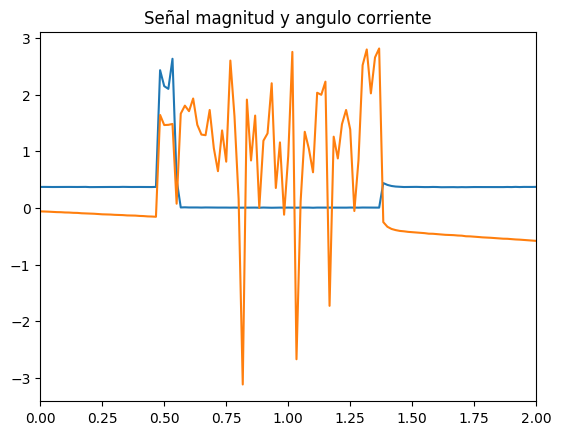

In [13]:
plt.plot(tm, rms_iA)
plt.plot(tm, angle_iA)
plt.title('Señal magnitud y angulo corriente')
plt.xlim(0, 2)
plt.show()

Ahora para el voltaje 

In [14]:
abs_vA,angle_vA,tm = fft_mag(data.vA, data.t)
rms_vA = rms_ve(abs_vA)

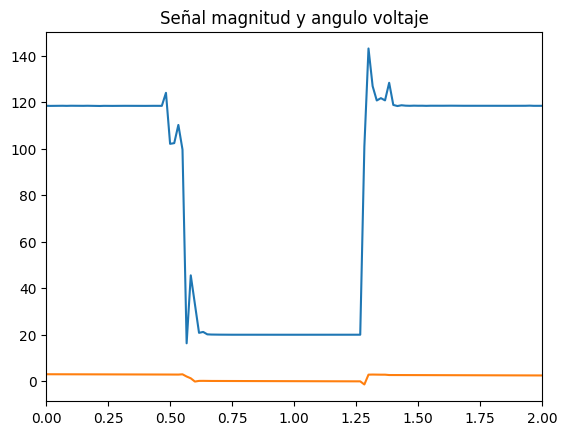

In [15]:
plt.plot(tm, rms_vA)
plt.plot(tm, angle_vA)
plt.title('Señal magnitud y angulo voltaje')
plt.xlim(0, 2)
plt.show()